In [1]:
import os
import cv2
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from datetime import datetime, timedelta
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from Dataset import *
from torchvision import transforms
from p_tqdm import p_umap
from functools import partial


In [2]:
frame_width,frame_height = 250,150
x,y = 450,780
pt1_L = (x, y)
pt2_L = (450+frame_width, 780+frame_height)
x,y = 1450,800
pt1_R = (x, y)
pt2_R = (x+frame_width, y+frame_height)

In [3]:
# Load Excel file
def load_excel_data(file_path):
    activation_df = pd.read_excel(file_path, sheet_name="Activation")
    non_activation_df = pd.read_excel(file_path, sheet_name="NonActivation")
    return activation_df, non_activation_df


In [127]:
# Process the dataset
video_dir = r"D:\LiDAR_Data\2ndPHB\Video\IntesectionVideo"
excel_file_path = r"D:\LiDAR_Data\2ndPHB\Video\Activation.xlsx"
output_dir = r"D:\LiDAR_Data\2ndPHB\Video\Dataset"
clip_save_dir = r"D:\LiDAR_Data\2ndPHB\Video\Clips"
time_window = 3 # seconds
# Load the Excel data
activation_df, non_activation_df = load_excel_data(excel_file_path)
excel_file_1 = r"D:\LiDAR_Data\2ndPHB\Video\HAWK Pedestrian Behavior.xlsx"
student_file = pd.read_excel(excel_file_1)

In [128]:
"""
Conbine the my labels and high school student labels
"""
student_activation_L = student_file.loc[(student_file.Bound == 'N') & (student_file.loc[:,'Pressed?'] == 'Y')].copy()
student_activation_R = student_file.loc[(student_file.Bound == 'S') & (student_file.loc[:,'Pressed?'] == 'Y')].copy()
# uniform the column names and data format
# combine Date column and Time column in student_activation_L and student_activation_R, and convert to YYYYMMDD_HHMMSS format
timestamp = student_activation_L['Date'].astype(str) + '_' + student_activation_L['Time'].astype(str)
timestamp = timestamp.str.replace(':','')
# eliminate '-' in the timestamp
timestamp = timestamp.str.replace('-','')
student_activation_L.loc[:,'timestamp'] = timestamp
timestamp = student_activation_R['Date'].astype(str) + '_' + student_activation_R['Time'].astype(str)
timestamp = timestamp.str.replace(':','')
timestamp = timestamp.str.replace('-','')
student_activation_R.loc[:,'timestamp'] = timestamp
# combine student_activation_L and student_activation_R to activation_df
student_activation_L.loc[:, 'location'] = 'L'
student_activation_R.loc[:, 'location'] = 'R'
student_activation_L = student_activation_L.loc[:,['timestamp','location']]
student_activation_R = student_activation_R.loc[:,['timestamp','location']]
student_activation = pd.concat([student_activation_L, student_activation_R], axis=0)
activation_df = pd.concat([activation_df, student_activation], axis=0)
# filter duplicate rows
activation_df.drop_duplicates(inplace=True)
temp = activation_df.loc[activation_df.location == "R"]
temp.loc[:,'location'] = "L"
non_activation_df = pd.concat([non_activation_df, temp], axis=0)
non_activation_df.drop_duplicates(inplace=True)

In [130]:
""" identify unvisited video files"""
video_dir = r"D:\LiDAR_Data\2ndPHB\Video\IntesectionVideo"
total_video_list = os.listdir(video_dir)
# video file format: 00_00_192.168.1.108_1_20241204_224500.avi
# activation record format: 20241204_224500
# identify the video files that are not in the excel file
total_record_list = activation_df["timestamp"].tolist() + non_activation_df["timestamp"].tolist()
# convert to timestamp
total_record_list = [datetime.strptime(record, "%Y%m%d_%H%M%S") for record in total_record_list]
total_record_list_ = []
for record in total_record_list:
    record = record - timedelta(minutes = record.minute % 5)
    record = record.replace(second = 0 )
    total_record_list_.append(record)
unique_record_list = list(set(total_record_list_))
unvisited_video_list = []
for video in total_video_list:
    video_start_timestamp = video[22:].split(".")[0]
    video_start_timestamp = datetime.strptime(video_start_timestamp, "%Y%m%d_%H%M%S")
    if video_start_timestamp not in unique_record_list:
        unvisited_video_list.append(video)
save_path = r'D:\LiDAR_Data\2ndPHB\Video\unvisited_video_list_0111.csv'
df = pd.DataFrame(unvisited_video_list)
df.to_csv(save_path, index = False)

In [131]:
""" Select ROI for the video clips"""
video_path = r'D:\LiDAR_Data\2ndPHB\Video\Dataset\L_signal\train\1_20241206_165239_L.mp4'
cap = cv2.VideoCapture(video_path)
frames = []
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frames.append(frame)
cap.release()
frames = np.array(frames) # (seq_len, h, w, c)
test_img = frames[30].copy()
w,h = 250,150
x,y = 450,780
pt1_L = (x, y)
pt2_L = (450+w, 780+h)
print(x,y,w,h)
cv2.rectangle(test_img, pt1_L, pt2_L, (255, 0, 0), 2)
plt.imshow(test_img)
# draw a rectangle around the object
plt.show()
# crop the image
cropped_img = test_img[y:y+h, x:x+w]
plt.imshow(cropped_img)
plt.show()

IndexError: index 30 is out of bounds for axis 0 with size 0

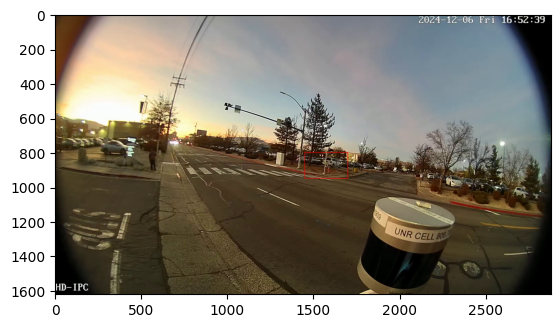

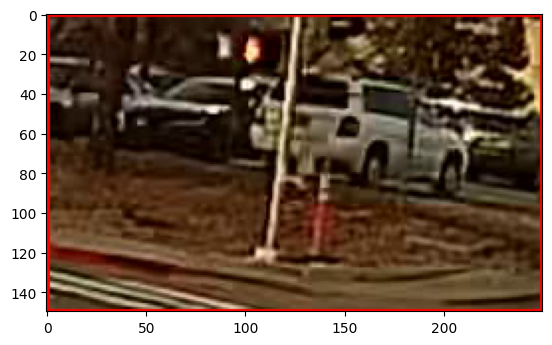

In [11]:
x,y = 1450,800
pt1_R = (x, y)
pt2_R = (x+w, y+h)
test_img = frames[30].copy()
cv2.rectangle(test_img, pt1_R, pt2_R, (255, 0, 0), 2)
plt.imshow(test_img)
# draw a rectangle around the object
plt.show()
# crop the image
cropped_img = test_img[y:y+h, x:x+w]
plt.imshow(cropped_img)
plt.show()

In [12]:
time_window = 3 # seconds (30 frames)
fps = 10
# Prepare data for activation and non-activation
date_times = []
start_frames = []
end_frames = []
save_names = []
for df, label in [(activation_df, 1), (non_activation_df, 0)]:
    for _, row in tqdm(df.iterrows()):
        record_timestamp = row["timestamp"]
        location = row["location"]
        # convert to datetime object
        record_timestamp = datetime.strptime(record_timestamp, "%Y%m%d_%H%M%S")
        
        # Match the video file with the timestamp
        for video_file in os.listdir(video_dir):
            video_start_timestamp = video_file[22:].split(".")[0]
            # convert to datetime object
            video_start_timestamp = datetime.strptime(video_start_timestamp, "%Y%m%d_%H%M%S")
            video_end_timestamp = video_start_timestamp + timedelta(seconds=60 * 5)
            if video_start_timestamp <= record_timestamp <= video_end_timestamp:
                # convert video_start_timestamp to '%Y-%m-%d-%H-%M-%S'
                video_start_timestamp_str = video_start_timestamp.strftime('%Y-%m-%d-%H-%M-%S')
                # window screening for the video clips making sure the record_timestamp is each 30 seconds
                screen_start_frame = int((record_timestamp - video_start_timestamp).seconds * fps)
                screen_end_frame = screen_start_frame + time_window * fps
                for step in range(2,18): # 2 frame margin for consevative screening
                    start_frame = int(screen_start_frame + step)
                    end_frame = int(screen_end_frame + step)
                    start_frames.append(start_frame)
                    end_frames.append(end_frame)
                    date_times.append(video_start_timestamp_str)
                    save_names.append(f"{label}_{video_start_timestamp_str}_{start_frame}_{location}.mp4")

288it [00:02, 133.69it/s]
405it [00:03, 131.95it/s]


In [28]:
# make the dataframe
# data = {"date_time": date_times, "start_frame": start_frames, "end_frame": end_frames, "save_name": save_names}
# df = pd.DataFrame(data)
# video file format: 00_00_192.168.1.108_1_20241204_224500.avi
target_video_paths = []
target_frames = []
save_names = []
locations = []
for date_time,g in df.groupby("date_time"):
    # convert date_time to YYYYMMDD_HHMMSS
    date_time = datetime.strptime(date_time, "%Y-%m-%d-%H-%M-%S").strftime("%Y%m%d_%H%M%S")
    video_file = f"00_00_192.168.1.108_1_{date_time}.avi"
    video_path = os.path.join(video_dir, video_file)
    target_video_paths.append(video_path)
    target_start_frames = g["start_frame"].tolist()
    target_end_frames = g["end_frame"].tolist()
    target_frames.append(np.c_[target_start_frames, target_end_frames])
    save_names.append(g["save_name"].tolist())
    locations.append(g["save_name"].str[-5].tolist())
    # break


In [39]:
frame_width,frame_height = 250,150
x,y = 450,780
pt1_L = (x, y)
pt2_L = (450+frame_width, 780+frame_height)
x,y = 1450,800
pt1_R = (x, y)
pt2_R = (x+frame_width, y+frame_height)
ROI_L, ROI_R = [pt1_L, pt2_L], [pt1_R, pt2_R]
def write_video(output_path, frames, fourcc, fps, frame_width, frame_height,location):
    """
    Writes a video file using OpenCV.

    Args:
        output_path (str): Path to save the video.
        frames (list): List of frames to write.
        fourcc (int): Codec.
        fps (int): Frames per second.
        frame_width (int): Width of the frame.
        frame_height (int): Height of the frame.
    """
    # Set up VideoWriter for saving the output
    out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))
    for frame in frames:
        if location == 'L':
            # crop the image to the ROI
            frame = frame[ROI_L[0][1]:ROI_L[1][1], ROI_L[0][0]:ROI_L[1][0]]
        elif location == 'R':
            frame = frame[ROI_R[0][1]:ROI_R[1][1], ROI_R[0][0]:ROI_R[1][0]]
        out.write(frame)
    # Release resources
    out.release()

def clip_single_video(input_video_path, save_names, target_frames, locations, output_folder):
    """
    Clips a video using OpenCV based on start and end timestamps.

    Args:
        input_path (str): Path to the input video file.
        output_path (str): Path to save the clipped video.
        start_time (float): Start time in seconds.
        end_time (float): End time in seconds.
    """
    # Open the video file
    cap = cv2.VideoCapture(input_video_path)
    
    if not cap.isOpened():
        print("Error: Cannot open video file.")
        return

    # Get video properties
    fps = int(cap.get(cv2.CAP_PROP_FPS))  # Frames per second
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec

    init_frame = target_frames[:,0].min()
    ending_frame = target_frames[:,1].max()
    current_frame = init_frame
    # Set the starting position of the video
    cap.set(cv2.CAP_PROP_POS_FRAMES, init_frame)

    frames = []
    frame_inds = []
    while current_frame <= ending_frame:
        ret, frame = cap.read()
        if not ret:
            # print("End of video reached or error reading frame.")
            break
        frames.append(frame)
        frame_inds.append(current_frame)
        current_frame += 1
    for i in range(len(target_frames)):
        start_frame = target_frames[i,0]
        end_frame = target_frames[i,1]
        start_ind = np.where(frame_inds == start_frame)[0][0]
        end_ind = np.where(frame_inds == end_frame)[0][0]
        save_name = save_names[i]
        location = locations[i]
        output_path = os.path.join(output_folder, save_name)
        write_video(output_path, frames[start_ind:end_ind], fourcc, fps, frame_width, frame_height,location)
    # Release resources
    cap.release()

In [ ]:
n_cpu = 4
output_folder = clip_save_dir
p_umap(
        partial(clip_single_video, output_folder=output_folder, cv2=cv2),
        target_video_paths,
        save_names,
        target_frames,
        locations,
        num_cpus = n_cpu
    )

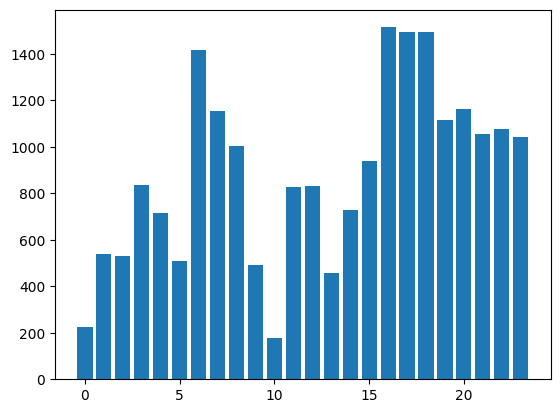

In [4]:
clip_save_dir = r"D:\LiDAR_Data\2ndPHB\Video\Clips"
video_dir = r"D:\LiDAR_Data\2ndPHB\Video\IntesectionVideo"
clips = os.listdir(clip_save_dir)
# format: {label}_2024-12-05-00-40-00_{frame}_{location}.mp4
# analyze hour distribution
hours = []
for clip in clips:
    timestamp = clip.split("_")[1]
    hour = timestamp.split("-")[3]
    hours.append(int(hour))
count_24 = np.zeros(24)
for hour in hours:
    count_24[hour] += 1
plt.bar(range(24), count_24)
plt.show()
extra_sample_number = 800 - count_24
extra_sample_number[extra_sample_number < 0] = 0
# sample the clips
empty_video_list = np.array(pd.read_excel(r'D:\LiDAR_Data\2ndPHB\Video\EmptyVideo.xlsx',header=None))
empty_video_list = np.array(empty_video_list).flatten()
# extract hour of the empty video
hour_empty_video = []
for video in empty_video_list:
    timestamp = video.split("_")[-1]
    hour = timestamp[:2]
    hour_empty_video.append(int(hour))
hour_empty_video = np.array(hour_empty_video)
for i in range(len(extra_sample_number)):
    if extra_sample_number[i] > 0:
        # sample the clips
        extra_number = extra_sample_number[i]
        empty_video_name = empty_video_list[hour_empty_video == i][0]
        empty_video_path = os.path.join(clip_save_dir, empty_video_name)

In [5]:
import shutil
# Split the dataset into train, validation,test with 80%, 10%, 10% respectively
clip_save_dir = r"D:\LiDAR_Data\2ndPHB\Video\Clips"
clips = os.listdir(clip_save_dir)
# Split the dataset into train, validation,test with 80%, 10%, 10% respectively
train_clips, test_clips = train_test_split(clips, test_size=0.2, random_state=42)
valid_clips, test_clips = train_test_split(test_clips, test_size=0.5, random_state=42)
train_folder = r'D:\LiDAR_Data\2ndPHB\Video\Dataset_0112\train'
valid_folder = r'D:\LiDAR_Data\2ndPHB\Video\Dataset_0112\valid'
test_folder = r'D:\LiDAR_Data\2ndPHB\Video\Dataset_0112\test'
os.makedirs(train_folder, exist_ok=True)
os.makedirs(valid_folder, exist_ok=True)
os.makedirs(test_folder, exist_ok=True)
for clip in train_clips:
    src = os.path.join(clip_save_dir, clip)
    dst = os.path.join(train_folder, clip)
    shutil.copy(src, dst)
for clip in valid_clips:
    src = os.path.join(clip_save_dir, clip)
    dst = os.path.join(valid_folder, clip)
    shutil.copy(src, dst)
for clip in test_clips:
    src = os.path.join(clip_save_dir, clip)
    dst = os.path.join(test_folder, clip)
    shutil.copy(src, dst)

In [30]:
# empty video list
empty_video_list = np.array(pd.read_excel(r'D:\LiDAR_Data\2ndPHB\Video\EmptyVideo.xlsx',header=None))
empty_video_list = np.array(empty_video_list).flatten()
output_folder = r'D:\LiDAR_Data\2ndPHB\Video\NewSampledClips_0'
os.makedirs(output_folder, exist_ok=True)
video_folder = r'D:\LiDAR_Data\2ndPHB\Video\IntesectionVideo'
for i in range(len(empty_video_list)):
    print(f"Processing {i+1}/{len(empty_video_list)}")
    video_file = empty_video_list[i] + '.avi'
    video_path = os.path.join(video_folder, video_file)
    date_str = empty_video_list[i][-15:]
    # convert date_str from YYYYMMDD_HHMMSS to YYYY-MM-DD-HH-MM-SS
    date = datetime.strptime(date_str, "%Y%m%d_%H%M%S").strftime("%Y-%m-%d-%H-%M-%S")
    cap = cv2.VideoCapture(video_path)
    fps = int(cap.get(cv2.CAP_PROP_FPS))  # Frames per second
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec
    frame_num = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    sampled_frames = np.random.choice(frame_num, 500, replace=False)
    if not cap.isOpened():
        print("Error: Cannot open video file.")
        continue
    L_frames = []
    R_frames = []
    cur_frame = 0
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        L_frame = frame[pt1_L[1]:pt2_L[1], pt1_L[0]:pt2_L[0]]
        R_frame = frame[pt1_R[1]:pt2_R[1], pt1_R[0]:pt2_R[0]]
        L_frames.append(L_frame)
        R_frames.append(R_frame)
        if cur_frame > frame_num:
            break
        cur_frame += 1
    cap.release()
    # crop the frames based on the sampled frames
    L_frames = np.array(L_frames)
    R_frames = np.array(R_frames)
    for j in tqdm(sampled_frames):
        start_frame = j
        end_frame = j + fps*3
        if end_frame > len(L_frames):
            continue
        if start_frame < 0:
            continue
        L_clip = L_frames[start_frame:end_frame]
        R_clip = R_frames[start_frame:end_frame]
        save_name = f"0_{date}_{start_frame}_L.mp4"
        out_path = os.path.join(output_folder, save_name)
        out = cv2.VideoWriter(out_path, fourcc, fps, (frame_width, frame_height))
        for frame in L_clip:
            out.write(frame)
        out.release()
        save_name = f"0_{date}_{start_frame}_R.mp4"
        out_path = os.path.join(output_folder, save_name)
        out = cv2.VideoWriter(out_path, fourcc, fps, (frame_width, frame_height))
        for frame in R_clip:
            out.write(frame)
        out.release()

Processing 1/25


100%|██████████| 500/500 [00:04<00:00, 101.88it/s]


Processing 2/25


100%|██████████| 500/500 [00:04<00:00, 103.29it/s]


Processing 3/25


100%|██████████| 500/500 [00:04<00:00, 104.39it/s]


Processing 4/25


100%|██████████| 500/500 [00:04<00:00, 105.93it/s]


Processing 5/25


100%|██████████| 500/500 [00:05<00:00, 99.29it/s] 


Processing 6/25


100%|██████████| 500/500 [00:05<00:00, 99.05it/s] 


Processing 7/25


100%|██████████| 500/500 [00:04<00:00, 101.38it/s]


Processing 8/25


100%|██████████| 500/500 [00:04<00:00, 104.20it/s]


Processing 9/25


100%|██████████| 500/500 [00:05<00:00, 99.91it/s] 


Processing 10/25


100%|██████████| 500/500 [00:04<00:00, 101.74it/s]


Processing 11/25


100%|██████████| 500/500 [00:04<00:00, 101.60it/s]


Processing 12/25


100%|██████████| 500/500 [00:04<00:00, 100.76it/s]


Processing 13/25


100%|██████████| 500/500 [00:04<00:00, 102.03it/s]


Processing 14/25


100%|██████████| 500/500 [00:04<00:00, 101.69it/s]


Processing 15/25


100%|██████████| 500/500 [00:04<00:00, 108.72it/s]


Processing 16/25


100%|██████████| 500/500 [00:04<00:00, 107.99it/s]


Processing 17/25


100%|██████████| 500/500 [00:04<00:00, 107.57it/s]


Processing 18/25


100%|██████████| 500/500 [00:04<00:00, 101.20it/s]


Processing 19/25


100%|██████████| 500/500 [00:04<00:00, 104.05it/s]


Processing 20/25


100%|██████████| 500/500 [00:04<00:00, 100.83it/s]


Processing 21/25


100%|██████████| 500/500 [00:04<00:00, 108.77it/s]


Processing 22/25


100%|██████████| 500/500 [00:04<00:00, 103.15it/s]


Processing 23/25


100%|██████████| 500/500 [00:05<00:00, 99.84it/s] 


Processing 24/25


100%|██████████| 500/500 [00:04<00:00, 103.13it/s]


Processing 25/25


100%|██████████| 500/500 [00:05<00:00, 88.47it/s] 


In [4]:
import shutil 
train_folder = r'D:\LiDAR_Data\2ndPHB\Video\Dataset\train'
valid_folder = r'D:\LiDAR_Data\2ndPHB\Video\Dataset\valid'
test_folder = r'D:\LiDAR_Data\2ndPHB\Video\Dataset\test'
sample_clip_folder = r'D:\LiDAR_Data\2ndPHB\Video\NewSampledClips_0'
sample_clips = os.listdir(sample_clip_folder)
# count the number of clips in the train and val and test folders
train_clips = os.listdir(train_folder)
val_clips = os.listdir(valid_folder)
test_clips = os.listdir(test_folder)
# count 0 and 1 in the train and val and test folders
train_labels = [int(clip.split('_')[0]) for clip in train_clips]
val_labels = [int(clip.split('_')[0]) for clip in val_clips]
test_labels = [int(clip.split('_')[0]) for clip in test_clips]

num_train = len(train_labels)
num_val = len(val_labels)
num_test = len(test_labels)
train_0 = train_labels.count(0) 
train_1 = train_labels.count(1)
val_0 = val_labels.count(0)
val_1 = val_labels.count(1)
test_0 = test_labels.count(0)
test_1 = test_labels.count(1)
# random sample 0 clips for val and train, such that the ratio of 0 and 1 will no greater than 2:1
# sample 0 clips for train
sample_0_train = int(np.ceil(train_1 * 2))
num_required_0_train = sample_0_train - train_0
# sample 0 clips for val
sample_0_val = int(np.ceil(val_1 * 2))
num_required_0_val = sample_0_val - val_0
# sample 0 clips for test
sample_0_test = int(np.ceil(test_1 * 2))
num_required_0_test = sample_0_test - test_0

sampled_clips_train = np.random.choice(sample_clips, num_required_0_train, replace=False)
sampled_clips_val = np.random.choice(sample_clips, num_required_0_val, replace=False)
sampled_clips_test = np.random.choice(sample_clips, num_required_0_test, replace=False)
# copy the sampled clips to the train and val and test folders
for clip in sampled_clips_train:
    src = os.path.join(sample_clip_folder, clip)
    dst = os.path.join(train_folder, clip)
    shutil.copy(src, dst)
for clip in sampled_clips_val:
    src = os.path.join(sample_clip_folder, clip)
    dst = os.path.join(valid_folder, clip)
    shutil.copy(src, dst)
for clip in sampled_clips_test:
    src = os.path.join(sample_clip_folder, clip)
    dst = os.path.join(test_folder, clip)
    shutil.copy(src, dst)





In [55]:
from Dataset import VideoDataset
import os
import cv2
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from datetime import datetime, timedelta
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.optim as optim
from Loss import FocalLoss
from torchvision import models
import albumentations as A
from Model import CNNLSTMAttention
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()

In [56]:
# Custom Transform for Normalization
def preprocessing(frames):
    """ Normalize frames (batch_size, seq_len, h, w, c) """
    # to tensor
    frames = torch.tensor(frames)
    frames = frames / 255.0  # Scale pixel values to [0, 1]
    mean = torch.tensor([0.485, 0.456, 0.406])  # Imagenet mean for RGB
    std = torch.tensor([0.229, 0.224, 0.225])  # Imagenet std for RGB
    frames = (frames - mean) / std  # Normalize
    frames = frames.to(torch.float32).permute(0,3,1,2)
    # frames = torch.nn.functional.interpolate(frames.permute(0,3,1,2), size=224, mode = 'bilinear', align_corners=False)
    return frames

transform_aug = A.Compose([
    A.RandomBrightnessContrast(p=0.5),
    A.Illumination(p=0.5),
    A.Equalize(p=0.5),
    A.RandomSunFlare(p=0.5,flare_roi=(0,0,1,0.5)),
    A.RandomShadow(p=0.5),
    A.ElasticTransform(p=0.3,alpha=1,sigma=50),
])

def create_data_loaders(train_dir, val_dir, batch_size=4, preprocess=None, augmentation=None):
    train_dataset = VideoDataset(train_dir, preprocess=preprocess, augmentation=augmentation)
    val_dataset = VideoDataset(val_dir, preprocess=preprocess)
    # test_dataset = VideoDataset(test_dir, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    # test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader

train_dir = r'D:\LiDAR_Data\2ndPHB\Video\Dataset\L_signal\train'
val_dir = r'D:\LiDAR_Data\2ndPHB\Video\Dataset\L_signal\val'
train_loader, val_loader = create_data_loaders(train_dir, val_dir, batch_size=2, preprocess=preprocessing, augmentation=transform_aug)

In [57]:
for i, (frames, label, location) in enumerate(train_loader):
    break

In [27]:
from sklearn.metrics import confusion_matrix
train_dir = r'D:\LiDAR_Data\2ndPHB\Video\Dataset\L_signal\train'
val_dir = r'D:\LiDAR_Data\2ndPHB\Video\Dataset\L_signal\val'
train_loader, val_loader = create_data_loaders(train_dir, val_dir, batch_size=2, preprocess=preprocessing, augmentation=transform_aug)
model_path = r"D:\LiDAR_Data\2ndPHB\Video\left_signal_0107\model\best_model.pth"
# model = ResNetLSTMWithAttention().to(device)
model = CNNLSTMAttention().to(device)
model.load_state_dict(torch.load(model_path,weights_only=True))
# calculate the confusion matrix
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    with tqdm(total=len(val_loader), desc="Validation") as pbar:
        for inputs, labels, _ in val_loader:
            inputs, labels = inputs.to(device), labels.to(device).float()
            outputs, attention_weights = model(inputs)
            # outputs = model(inputs)
            outputs = torch.flatten(outputs)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(outputs.cpu().numpy())
            pbar.update(1)
y_true = np.array(y_true)
y_pred = np.array(y_pred)
confidence_thresholds = np.arange(0.1, 0.9, 0.1)
precision_scores = []
recall_scores = []
F1_scores = []

for threshold in confidence_thresholds:
    y_pred_thresholded = (y_pred > threshold).astype(int)
    conf_matrix = confusion_matrix(y_true, y_pred_thresholded)
    precision = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[0, 1])
    recall = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[1, 0])
    F1 = 2 * precision * recall / (precision + recall)

    precision_scores.append(precision)
    recall_scores.append(recall)
    F1_scores.append(F1)


Validation: 100%|██████████| 571/571 [00:21<00:00, 26.00it/s]


In [34]:
# dataset statistics for validation set
val_dir = r'D:\LiDAR_Data\2ndPHB\Video\Dataset\L_signal\val'
val_dataset = VideoDataset(val_dir, preprocess=preprocessing)
# calculate number of 1 and 0 labels
num_1 = 0
num_0 = 0
for i in range(len(val_dataset)):
    _, label, _ = val_dataset[i]
    if label == 1:
        num_1 += 1
    else:
        num_0 += 1
print(num_1, num_0)


593 548


TP: 580, FP: 5, FN: 13, TN: 543


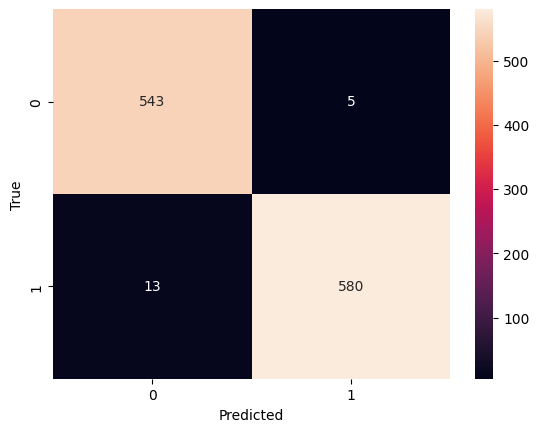

In [33]:
#calcualte confusion matrix at 0.5 threshold
threshold = 0.5
y_pred_thresholded = (y_pred > threshold).astype(int)
conf_matrix = confusion_matrix(y_true, y_pred_thresholded)
precision = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[0, 1])
recall = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[1, 0])
F1 = 2 * precision * recall / (precision + recall)
conf_matrix, precision, recall, F1
TP,FP,FN,TN = conf_matrix[1,1],conf_matrix[0,1],conf_matrix[1,0],conf_matrix[0,0]
print(f"TP: {TP}, FP: {FP}, FN: {FN}, TN: {TN}")
# plot graph of confusion matrix 
import seaborn as sns
sns.heatmap(conf_matrix, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

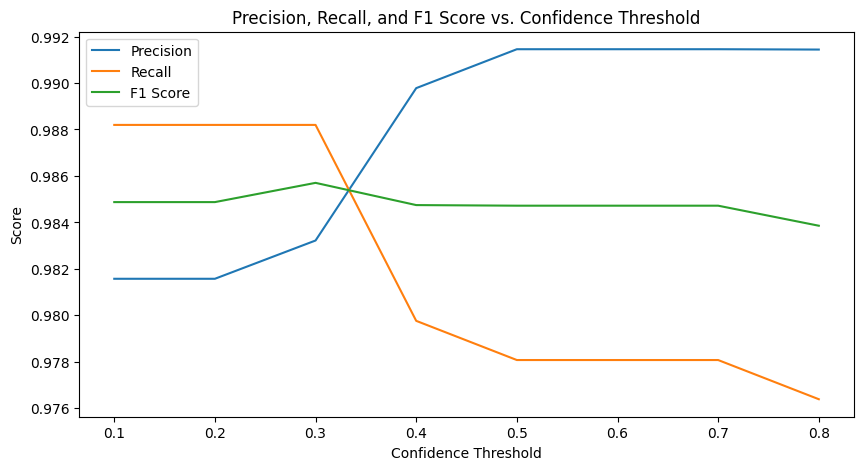

In [29]:
# plot the precision, recall and F1 score curves
plt.figure(figsize=(10, 5))
plt.plot(confidence_thresholds, precision_scores, label="Precision")
plt.plot(confidence_thresholds, recall_scores, label="Recall")
plt.plot(confidence_thresholds, F1_scores, label="F1 Score")
plt.xlabel("Confidence Threshold")
plt.ylabel("Score")
plt.legend()
plt.title("Precision, Recall, and F1 Score vs. Confidence Threshold")
plt.show()

### Inference

In [1]:
from Dataset import VideoDataset,preprocessing,transform_aug
from Model import CNNLSTMAttention
import os
import cv2
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from datetime import datetime, timedelta
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.optim as optim
from Loss import *
from torchvision import models
from MotionAppearanceFusion import TwoStreamModel
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()
mean = torch.tensor([0.485, 0.456, 0.406])  # Imagenet mean for RGB
std = torch.tensor([0.229, 0.224, 0.225])  # Imagenet std for RGB

In [2]:
frame_width,frame_height = 250,150
x,y = 450,780
pt1_L = (x, y)
pt2_L = (450+frame_width, 780+frame_height)
x,y = 1450,800
pt1_R = (x, y)
pt2_R = (x+frame_width, y+frame_height)
ROI_L, ROI_R = [pt1_L, pt2_L], [pt1_R, pt2_R]

In [13]:
model_path = r"D:\LiDAR_Data\2ndPHB\Video\overall_0111_FocalLoss_0840\model\best_model.pth" 
model = CNNLSTMAttention(cnn_output_dim=128,
    lstm_hidden_dim=128,
    lstm_layers=1).to(device)
model.load_state_dict(torch.load(model_path,weights_only=True))
model.eval()

CNNLSTMAttention(
  (cnn): CNNFeatureExtractor(
    (cnn): Sequential(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Dropout(p=0.3, inplace=False)
      (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): ReLU()
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (7): Dropout(p=0.5, inplace=False)
      (8): Flatten(start_dim=1, end_dim=-1)
      (9): Linear(in_features=73408, out_features=128, bias=True)
      (10): ReLU()
      (11): Dropout(p=0.5, inplace=False)
    )
  )
  (lstm): LSTM(128, 128, batch_first=True)
  (attention): Attention(
    (attention_weights): Linear(in_features=128, out_features=1, bias=True)
  )
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [14]:
def predict(model, frames, device):
    model.eval()
    with torch.no_grad():
        frames = preprocessing(frames,device)
        # shape: (ROI, seq_len, c, h, w)
        outputs, attention_weights = model(frames)
        outputs = torch.flatten(outputs)
        return outputs.cpu().numpy()

In [15]:
def preprocessing(cur_video,device):
    cur_video = np.array(cur_video)
    cur_video = torch.tensor(cur_video)
    cur_video = cur_video / 255.0
    cur_video = (cur_video - mean ) / std
    cur_video = cur_video.permute(1,0,4,2,3)
    cur_video = cur_video.to(device)
    batch_size, seq_len, c, h, w = cur_video.size()
    x = cur_video.reshape(batch_size * seq_len, c, h, w) 
    x = x.view(batch_size, seq_len, c, h, w)
    return x

In [18]:
ROIs = [ROI_L, ROI_R]
video_path = r'D:\LiDAR_Data\2ndPHB\Video\IntesectionVideo\00_00_192.168.1.108_1_20241208_112000.avi'
# save as mp4 format
save_path  = r'D:\LiDAR_Data\2ndPHB\Video\test_out\00_00_192.168.1.108_1_20241208_112000.mp4'
frame_window = 30 # 3 seconds
font = cv2.FONT_HERSHEY_SIMPLEX
font_scale = 1
font_color = (255, 255, 255)
line_type = 2

cap = cv2.VideoCapture(video_path)
fps = cap.get(cv2.CAP_PROP_FPS)
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
raw_video_height, raw_video_width = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)), int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
out = cv2.VideoWriter(save_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (raw_video_width, raw_video_height))
prediction_sequence = [] # store the predicted vectors
cur_video = []
for _ in range(frame_window):
    ret, cur_raw_frame = cap.read()
    if not ret:
        break
    # for each frame, crop the frame within ROIs for prediction, shape: (ROI_ind,h,w,c)
    cur_raw_frame_rgb = cv2.cvtColor(cur_raw_frame, cv2.COLOR_BGR2RGB)
    frames_rgb_ROI = [] 
    for ROI in ROIs:
        frame = cur_raw_frame_rgb[ROI[0][1]:ROI[1][1], ROI[0][0]:ROI[1][0]]
        # frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames_rgb_ROI.append(frame)
    frames_rgb_ROI = np.array(frames_rgb_ROI)
    cur_video.append(frames_rgb_ROI)
cur_frame_ind = frame_window
prediction = predict(model, cur_video, device)
# plot prediction value in right bottom corner of the raw frame and write to the video
for i,ROI in enumerate(ROIs):
    cv2.putText(cur_raw_frame, str(prediction[i]), (ROI[1][0], ROI[1][1]), font, font_scale, font_color, line_type)
out.write(cur_raw_frame)
prediction_sequence.append(prediction)
p_bar = tqdm(total=total_frames - frame_window)
while cap.isOpened():
    ret, cur_frame = cap.read()
    if not ret:
        break
    cur_raw_frame_rgb = cv2.cvtColor(cur_frame, cv2.COLOR_BGR2RGB)
    frames_rgb_ROI = []
    for ROI in ROIs:
        frame = cur_raw_frame_rgb[ROI[0][1]:ROI[1][1], ROI[0][0]:ROI[1][0]]
        frames_rgb_ROI.append(frame)
    frames_rgb_ROI = np.array(frames_rgb_ROI)
    cur_video.pop(0)
    cur_video.append(frames_rgb_ROI)
    prediction = predict(model, cur_video, device)
    for i,ROI in enumerate(ROIs):
        cv2.putText(cur_frame, str(prediction[i]), (ROI[1][0], ROI[1][1]), font, font_scale, font_color, line_type)
    out.write(cur_frame)
    prediction_sequence.append(prediction)
    p_bar.update(1)
cap.release()
out.release()
p_bar.close()

100%|██████████| 2970/2970 [03:30<00:00, 14.13it/s]
